In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 37.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 36.0 MB/s eta 0:00:00


In [12]:
import torch

In [4]:
# 导入BertForQuestionAnswering模块
# BertForQuestionAnswering是一个预训练的BERT模型，专门用于问题回答任务在
# 问题回答任务中，模型需要根据给定的问题和文本，找出文本中回答问题的部分
from transformers import BertForQuestionAnswering

# 加载预训练模型
# 使用from_pretrained方加载一个预训练的模型'bert-large-uncased-whole-word-masking-finetuned-squad'
# 是在大型BERT模型（'bert-large-uncased'）的基础上，使用whole word masking方法和squad数据集进行的微调得到的
# 你可以拿自己的QA数据集来训练，但是需要耗费大量的资源和时间
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')


In [5]:
# 导入BertTokenizer模块
# BertTokenizer是用于BERT模型的分词器
# 分词器的作用是将文本划分为词语或者词语片段，这些词语或者词语片段会被转化为模型可以处理的数字ID, 也就是 Tokenizer 化
from transformers import BertTokenizer

# 加载预训练的分词器
# 使用from_pretrained方法来加载一个预训练的分词器
# 'bert-large-uncased-whole-word-masking-finetuned-squad'是分词器的名字，这个分词器是专门用于配合'bert-large-uncased-whole-word-masking-finetuned-squad'模型的
# 虽然Bert——base有自己的default 分词器，但是针对特化任务创建的分词器一般而言是更有效的
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')


In [6]:
# 提供一个QA文本内容
# 后续我们就拿这对文本对来进行操作处理
question = "How many parameters does BERT-large have?"
answer_text = "BERT-large is really big... it has 24-layers and an embedding size of 1,024, for a total of 340M parameters! Altogether it is 1.34GB, so expect it to take a couple minutes to download to your Colab instance."

In [7]:
# 使用分词器对输入文本进行编码，把它们看作是一个文本对。
# 在这里，"question"是问题文本，"answer_text"是可能包含答案的文本
# tokenizer.encode方法会将文本对转化为一系列的数字ID。
input_ids = tokenizer.encode(question, answer_text)

# 打印转化后的数字ID的数量，这个数量也就是原始文本的token数量
# 注意，输入文本的长度 != token 的长度，因为Tokenizer 中存在 words to subwords 的过程
print('The input has a total of {:} tokens.'.format(len(input_ids)))


The input has a total of 70 tokens.


In [8]:
# BERT模型只需要token ID，但是为了检查分词器的行为，打印token id 帮助理解
tokens = tokenizer.convert_ids_to_tokens(input_ids)

# 对于每一个token及其ID进行zip处理
for token, id in zip(tokens, input_ids):
    
    # 如果这是[SEP] token，就在它周围加一些空格，使它突出显示
    if id == tokenizer.sep_token_id:
        print('')
    
    # 使用两列打印token字符串和它的ID
    print('{:<12} {:>6,}'.format(token, id))

    # 如果这是[SEP] token，就在它周围加一些空格，使它突出显示
    if id == tokenizer.sep_token_id:
        print('')


[CLS]           101
how           2,129
many          2,116
parameters   11,709
does          2,515
bert         14,324
-             1,011
large         2,312
have          2,031
?             1,029

[SEP]           102

bert         14,324
-             1,011
large         2,312
is            2,003
really        2,428
big           2,502
.             1,012
.             1,012
.             1,012
it            2,009
has           2,038
24            2,484
-             1,011
layers        9,014
and           1,998
an            2,019
em            7,861
##bed         8,270
##ding        4,667
size          2,946
of            1,997
1             1,015
,             1,010
02            6,185
##4           2,549
,             1,010
for           2,005
a             1,037
total         2,561
of            1,997
340          16,029
##m           2,213
parameters   11,709
!               999
altogether   10,462
it            2,009
is            2,003
1             1,015
.             1,01

In [9]:
# Bert 需要一个embedding来帮助区分 Question 和 Answer
# 在送进模型之前，需要将 Question 序列加上一个 Q-Token，同理 Answer-Token

# 在input_ids中寻找第一个[SEP] token的位置
# [SEP] token在BERT中用来分隔两个句子，所以它的位置可以用于分辨哪些token属于第一个句子，哪些token属于第二个句子
sep_index = input_ids.index(tokenizer.sep_token_id)

# segment A的token数量包括[SEP] token本身
# 因此[SEP] token之前（包括[SEP] token）的所有token都属于segment A
num_seg_a = sep_index + 1

# 剩下的token都属于segment B
num_seg_b = len(input_ids) - num_seg_a

# 构造由0和1组成的列表
# 这个列表表示每个token属于哪个segment
# 0表示属于segment A，1表示属于segment B
segment_ids = [0]*num_seg_a + [1]*num_seg_b

# 每个输入token都应该有一个对应的segment ID
# 所以我们检查segment_ids的长度是否等于input_ids的长度
# 如果不等，代码一定有bug
assert len(segment_ids) == len(input_ids)


注意！
- 这里因为我们仅采用一段文本对作为输入，且输入的长度是可控的，因此我们没有进行 Padding 或 Truncate 操作
- 在批量操作过程中，我们是需要加上 Padding 和 Truncate 操作确保模型接受的数据长度是一致且小于 Max len的

In [14]:
# 将我们的示例运行在模型上
outputs = model(torch.tensor([input_ids]), # 代表我们输入文本的token
                token_type_ids=torch.tensor([segment_ids]), # 区分问题和答案文本的segment ID
                return_dict=True) # 设置为True，使模型返回一个包含更多信息的字典

# 获取开始和结束得分
start_scores = outputs.start_logits
end_scores = outputs.end_logits


In [15]:
# 找到开始和结束得分最高的token
# torch.argmax函数可以返回tensor中最大值的索引
# 使用这个函数找到开始得分和结束得分最高的token的位置
answer_start = torch.argmax(start_scores)
answer_end = torch.argmax(end_scores)

# 将答案中的token组合起来并打印出来
# 使用python的切片操作和join函数将答案中的token组合成一个字符串
answer = ' '.join(tokens[answer_start:answer_end+1])

print('Answer: "' + answer + '"')


Answer: "340 ##m"


注意！
- 这里我们简单无脑地选取了得分最高的start pos 和 end pos
- 但是在实际场景中我们需要考虑start pos index 大于 end pos index 的异常场景

In [16]:
# 从第一个token开始处理
answer = tokens[answer_start]

# 选择剩下的答案token并用空格连接它们
for i in range(answer_start + 1, answer_end + 1):
    
    # 如果它是一个子词token，那么就将它和前一个token重新组合
    # 在subwords中，我们使用 ##XX 代表某个subword与其前的subword是一体的
    # 子词token在BERT的tokenizer中以"##"开始，所以通过检查token的前两个字符是否为"##"来判断它是否为一个子词token
    if tokens[i][0:2] == '##':
        answer += tokens[i][2:]
    
    # 否则，在token前添加一个空格，然后添加token
    else:
        answer += ' ' + tokens[i]

print('Answer: "' + answer + '"')


Answer: "340m"


In [18]:
# 导入绘图库
import matplotlib.pyplot as plt
import seaborn as sns

# 使用seaborn的样式
sns.set(style='darkgrid')

# 增大图像和字体大小
plt.rcParams["figure.figsize"] = (16,8)

# 从PyTorch的Tensor中提取得分，并将它们转换为1D numpy数组
s_scores = start_scores.detach().numpy().flatten()
e_scores = end_scores.detach().numpy().flatten()

# 使用tokens作为x轴标签
# token 是 identical 的
# 将每个token的索引添加到其后面
token_labels = []
for (i, token) in enumerate(tokens):
    token_labels.append('{:} - {:>2}'.format(token, i))
    
import pandas as pd

# 将token和得分存储在DataFrame中。 
# 每个token将有两行，一行是其开始得分，另一行是其结束得分
# "marker"列将区分它们
scores = []
for (i, token_label) in enumerate(token_labels):

    # 添加token的开始得分作为一行。
    scores.append({'token_label': token_label, 
                   'score': s_scores[i],
                   'marker': 'start'})
    
    # 添加token的结束得分作为另一行。
    scores.append({'token_label': token_label, 
                   'score': e_scores[i],
                   'marker': 'end'})
    
df = pd.DataFrame(scores)


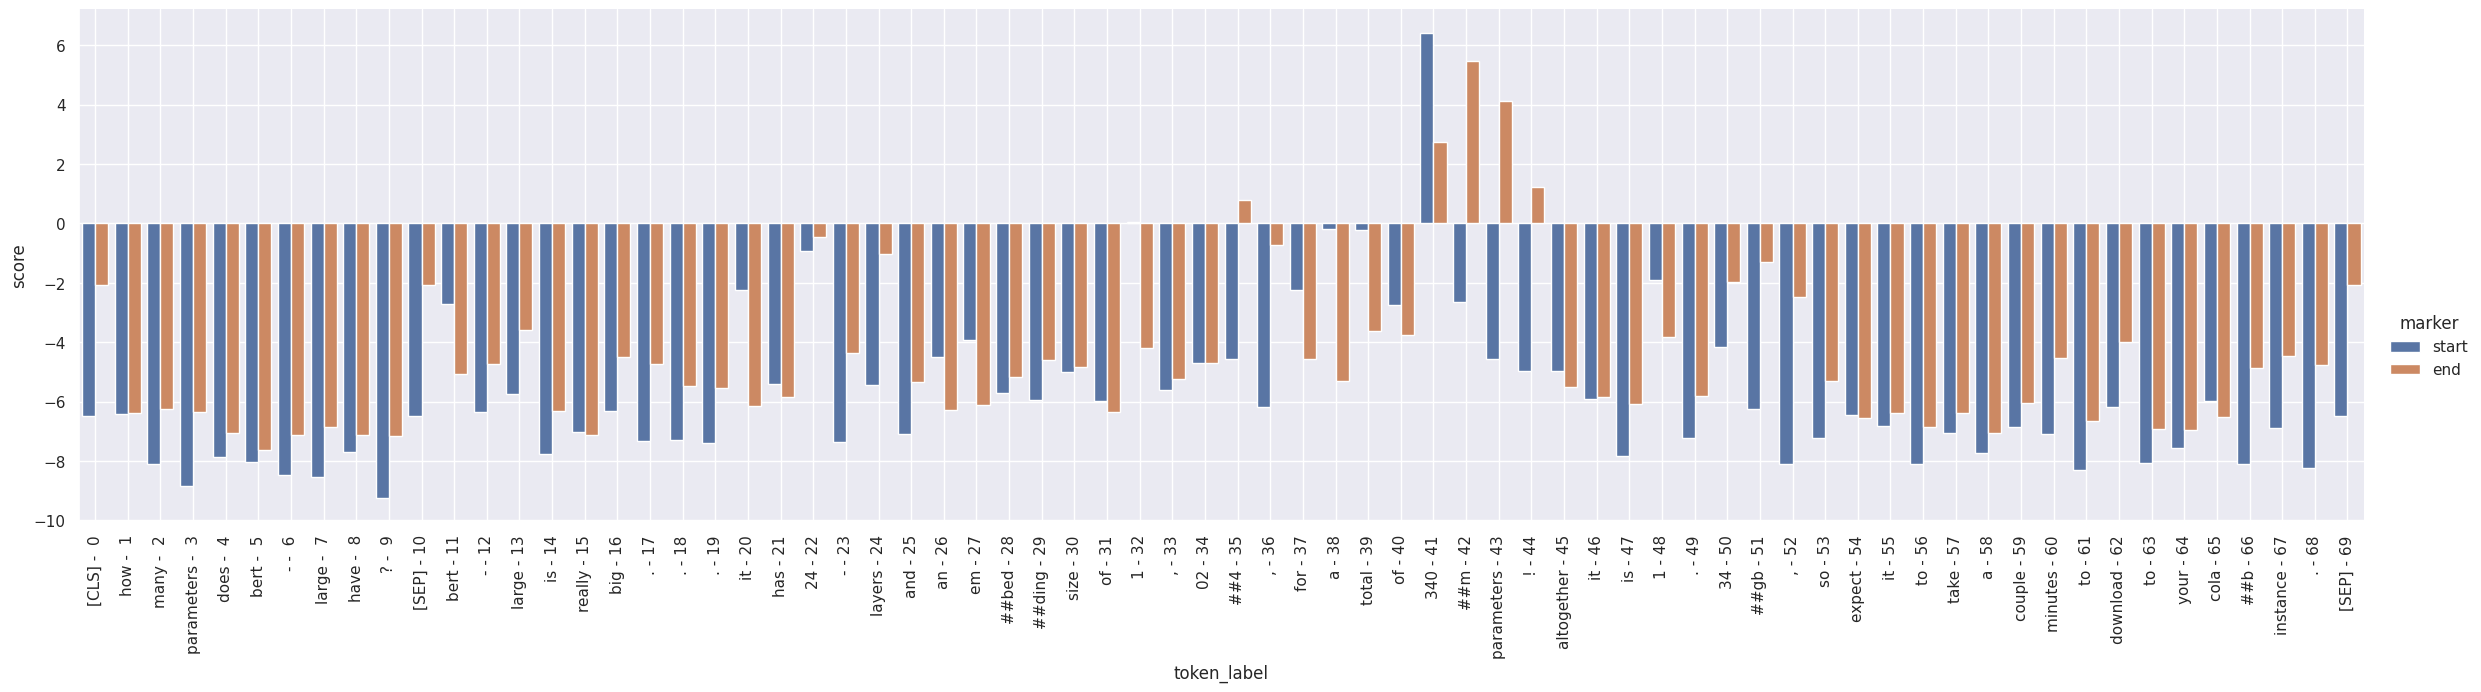

In [19]:
# 使用 seaborn 的 catplot 函数创建分组条形图，展示每个词的开始得分和结束得分
# "hue" 参数指定哪些数据点属于哪个系列的地方
g = sns.catplot(x="token_label", y="score", hue="marker", data=df,
                kind="bar", height=6, aspect=4)

# 将 x 轴标签旋转为垂直方向
g.set_xticklabels(g.ax.get_xticklabels(), rotation=90, ha="center")

# 打开垂直网格以帮助对齐单词和得分
g.ax.grid(True)
